# Localized Entropy Notebook

This notebook runs the end-to-end pipeline using the config in `configs/default.json`.
Switch between synthetic and CTR data, tune the model, and toggle plots from the config file.


In [1]:
%matplotlib inline
import numpy as np
import torch

from localized_entropy.config import load_and_resolve, loss_label
from localized_entropy.utils import init_device, set_seed
from localized_entropy.data.pipeline import prepare_data
from localized_entropy.models import ConditionProbNet
from localized_entropy.training import train_with_epoch_plots, evaluate, predict_probs
from localized_entropy.analysis import (
    print_pred_summary,
    collect_le_stats_per_condition,
    collect_logits,
    bce_log_loss,
    expected_calibration_error,
    per_condition_metrics,
)
from localized_entropy.plotting import (
    plot_training_distributions,
    plot_eval_log10p_hist,
    plot_loss_curves,
    plot_eval_predictions_by_condition,
    plot_le_stats_per_condition,
    plot_ctr_filter_stats,
)

np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4)

CONFIG_PATH = "configs/default.json"
cfg = load_and_resolve(CONFIG_PATH)
print(f"Using experiment: {cfg['experiment'].get('name', cfg['experiment'].get('active', 'unknown'))}")

device, use_cuda, non_blocking = init_device()
set_seed(cfg['project']['seed'], use_cuda)


Using experiment: baseline
CUDA not available, defaulting to CPU.


Loading CTR dataset...
Train rows: 10,000,000 | Test rows: 4,577,464
Filtering to top 3 values of C14: [21767, 21768, 19251]
Filtered Train rows: 1,089,105 | Filtered Test rows: 0
Train/Eval DataLoader workers: 0/0 (pin_memory=False) | Test workers: 0 | DataLoader workers disabled (set allow_dataloader_workers=true to enable).
Top-filter stats (click):
       frequency  median       std
C14                               
21767     376105     0.0  0.304487
21768     373692     0.0  0.305673
19251     339308     0.0  0.267716


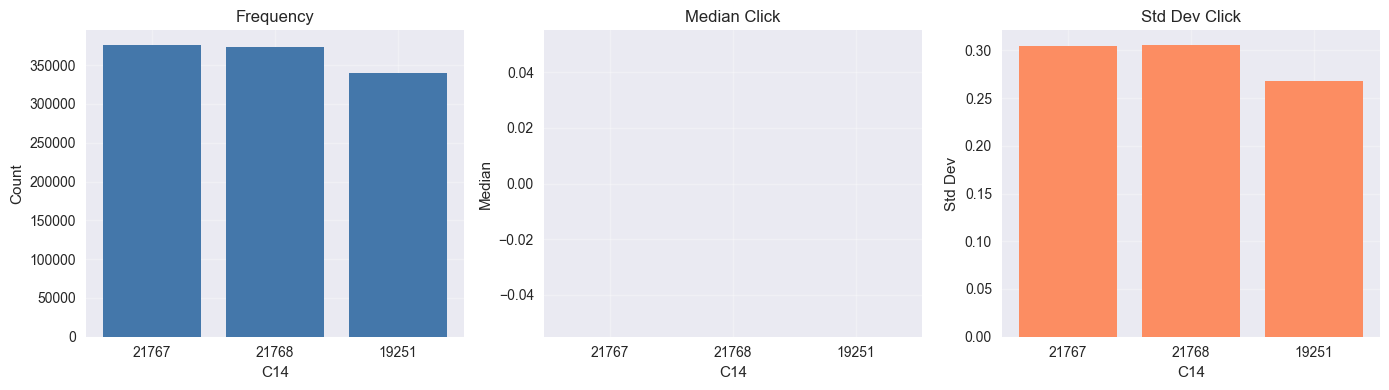

Skipping training data distribution plots before training.


In [2]:
data_bundle = prepare_data(cfg, device, use_cuda)
splits = data_bundle.splits
loaders = data_bundle.loaders
plots_cfg = cfg['plots']

if cfg.get('logging', {}).get('print_loader_note', True):
    print(loaders.loader_note)

if cfg.get('ctr', {}).get('plot_filter_stats', False):
    ctr_stats = data_bundle.plot_data.get('ctr_stats')
    if ctr_stats:
        plot_ctr_filter_stats(ctr_stats['stats_df'], ctr_stats['labels'], ctr_stats['filter_col'])

if plots_cfg.get('data_before_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        print('Training distribution plots are only available for synthetic data.')
else:
    print('Skipping training data distribution plots before training.')


In [3]:
model_cfg = cfg['model']
num_numeric = splits.x_train.shape[1]
model = ConditionProbNet(
    num_conditions=splits.num_conditions,
    num_numeric=num_numeric,
    embed_dim=model_cfg['embed_dim'],
    hidden_sizes=tuple(model_cfg['hidden_sizes']),
    p_drop=model_cfg['dropout'],
).to(device)
model


ConditionProbNet(
  (embedding): Embedding(4, 16)
  (net): Sequential(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [4]:
train_cfg = cfg['training']
train_losses, eval_losses = train_with_epoch_plots(
    model=model,
    train_loader=loaders.train_loader,
    val_loader=loaders.eval_loader,
    device=device,
    epochs=train_cfg['epochs'],
    lr=train_cfg['lr'],
    l2_weight_decay=train_cfg['l2_weight_decay'],
    non_blocking=non_blocking,
    plot_eval_hist_epochs=plots_cfg.get('eval_hist_epochs', False),
    loss_mode=train_cfg['loss_mode'],
)


Epoch   1/12 | Train LE: 0.000281 | Eval LE: 0.000309 | wall 9.92s
Epoch   2/12 | Train LE: 0.000264 | Eval LE: 0.000292 | wall 9.89s
Epoch   3/12 | Train LE: 0.000247 | Eval LE: 0.000271 | wall 9.84s
Epoch   4/12 | Train LE: 0.000228 | Eval LE: 0.000250 | wall 9.83s
Epoch   5/12 | Train LE: 0.000211 | Eval LE: 0.000233 | wall 9.72s
Epoch   6/12 | Train LE: 0.000198 | Eval LE: 0.000221 | wall 9.84s
Epoch   7/12 | Train LE: 0.000191 | Eval LE: 0.000215 | wall 10.31s
Epoch   8/12 | Train LE: 0.000186 | Eval LE: 0.000211 | wall 9.80s
Epoch   9/12 | Train LE: 0.000184 | Eval LE: 0.000209 | wall 9.57s
Epoch  10/12 | Train LE: 0.000183 | Eval LE: 0.000208 | wall 9.57s
Epoch  11/12 | Train LE: 0.000182 | Eval LE: 0.000207 | wall 9.83s
Epoch  12/12 | Train LE: 0.000181 | Eval LE: 0.000207 | wall 9.92s
Final Train LE: 0.0001814445
Final Eval  LE: 0.0002070355


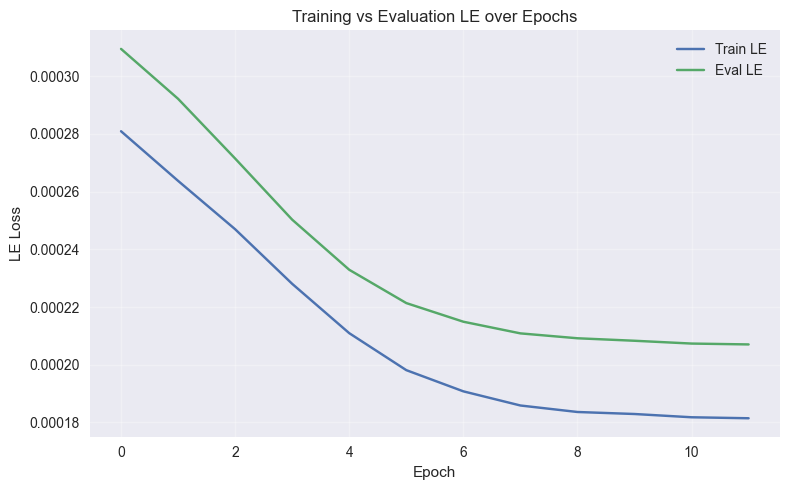

In [5]:
label = loss_label(train_cfg['loss_mode'])
if plots_cfg.get('loss_curves', True):
    plot_loss_curves(train_losses, eval_losses, label)


Eval prediction summary:
  n=108,911 mean=0.324947 std=0.000000
  min=0.324947 p01=0.324947 p05=0.324947 p50=0.324947 p95=0.324947 p99=0.324947 max=0.324947
  label base_rate=0.094077 | logloss=0.461747 | brier=0.138528 | acc@0.5=0.905923
  Top 8 conditions by count:
      count  pred_mean  label_mean
cond                              
0     37559   0.324947    0.102292
1     37186   0.324947    0.101813
2     34166   0.324947    0.076626


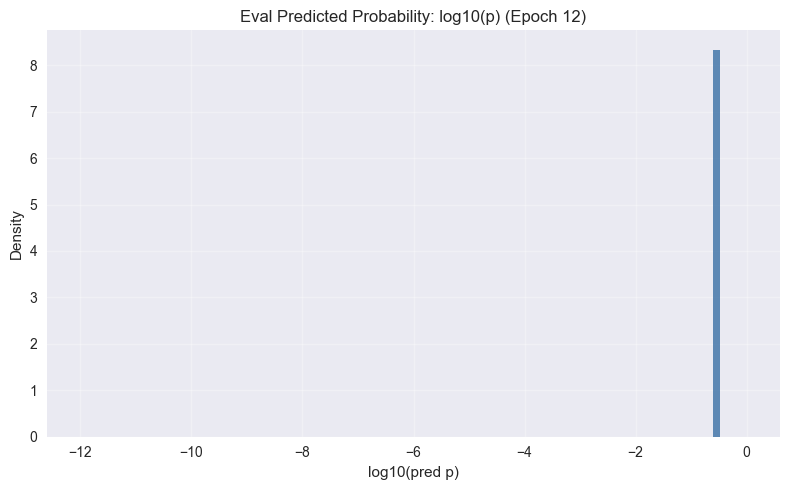

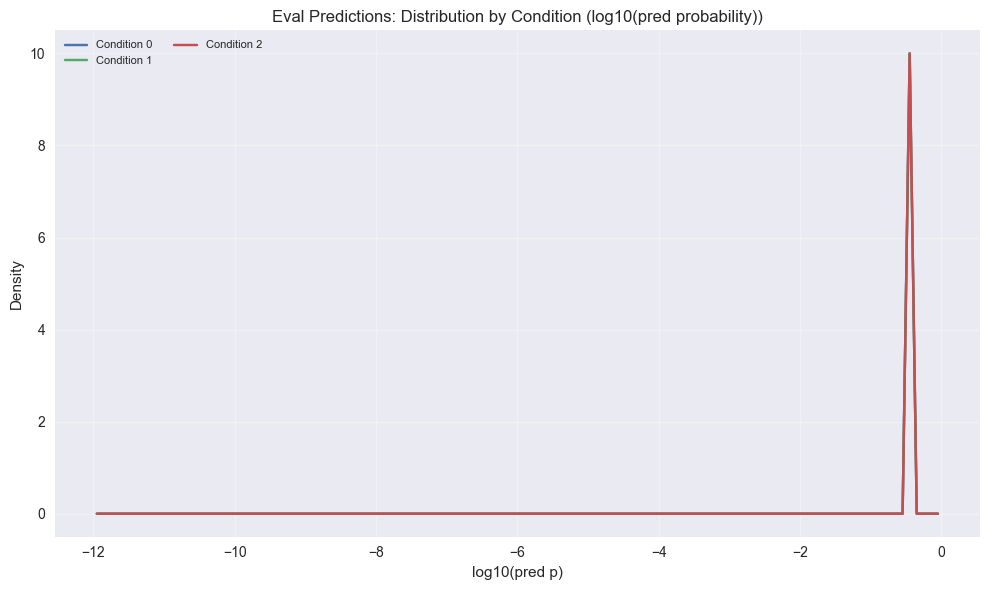

Final Evaluation LE: 0.0002070355
Total BCE (log loss): 0.46174684
Total ECE: 0.23087063
Total ECE (small p<= 0.01): nan
 condition  count  base_rate      bce      ece  ece_small
         0  37559   0.102292 0.467753 0.222655        NaN
         1  37186   0.101813 0.467403 0.223135        NaN
         2  34166   0.076626 0.448988 0.248322        NaN
Final Evaluation BCE: 0.4617469028


In [6]:
eval_loss, eval_preds = evaluate(
    model,
    loaders.eval_loader,
    device,
    loss_mode=train_cfg['loss_mode'],
    non_blocking=non_blocking,
)
if plots_cfg.get('print_eval_summary', True):
    print_pred_summary('Eval', eval_preds, labels=splits.y_eval, conds=splits.c_eval)

if plots_cfg.get('eval_pred_hist', True):
    plot_eval_log10p_hist(eval_preds.astype(np.float32), epoch=train_cfg['epochs'])

if plots_cfg.get('eval_pred_by_condition', True):
    plot_eval_predictions_by_condition(eval_preds, splits.c_eval, splits.num_conditions)

print(f"Final Evaluation {label}: {eval_loss:.10f}")
eval_cfg = cfg.get('evaluation', {})
bins = int(eval_cfg.get('ece_bins', 20))
min_count = int(eval_cfg.get('ece_min_count', 1))
small_prob_max = float(eval_cfg.get('small_prob_max', 0.01))

total_bce = bce_log_loss(eval_preds, splits.y_eval)
total_ece, total_ece_table = expected_calibration_error(
    eval_preds, splits.y_eval, bins=bins, min_count=min_count
)
small_mask = eval_preds <= small_prob_max
if small_mask.any():
    total_ece_small, _ = expected_calibration_error(
        eval_preds[small_mask],
        splits.y_eval[small_mask],
        bins=bins,
        min_count=min_count,
    )
else:
    total_ece_small = float('nan')

print(f"Total BCE (log loss): {total_bce:.8f}")
print(f"Total ECE: {total_ece:.8f}")
print(f"Total ECE (small p<= {small_prob_max:g}): {total_ece_small:.8f}")

if eval_cfg.get('print_calibration_table', False):
    print(total_ece_table.to_string(index=False))

per_ad = per_condition_metrics(
    eval_preds,
    splits.y_eval,
    splits.c_eval,
    bins=bins,
    min_count=min_count,
    small_prob_max=small_prob_max,
)
if eval_cfg.get('print_per_ad', True):
    top_k = int(eval_cfg.get('per_ad_top_k', 10))
    print(per_ad.head(top_k).to_string(index=False))

for mode in train_cfg.get('eval_compare_losses', []):
    if mode == train_cfg['loss_mode']:
        continue
    other_loss, _ = evaluate(
        model,
        loaders.eval_loader,
        device,
        loss_mode=mode,
        non_blocking=non_blocking,
    )
    other_label = loss_label(mode)
    print(f"Final Evaluation {other_label}: {other_loss:.10f}")


In [7]:
if loaders.test_loader is not None:
    test_preds = predict_probs(
        model,
        loaders.test_loader,
        device,
        non_blocking=non_blocking,
    )
    if test_preds.size > 0:
        if plots_cfg.get('print_eval_summary', True):
            print_pred_summary('Test', test_preds, labels=None, conds=splits.c_test)
    else:
        print('Test set is empty after filtering; skipping summary.')


Test set is empty after filtering; skipping summary.


In [8]:
if plots_cfg.get('data_after_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        print('Post-training plots are only available for synthetic data.')
else:
    print('Post-training training data plots are disabled.')


Post-training plots are only available for synthetic data.


cond	num	den	avg_p	#y=1	#y=0	ratio
0	17568.4	12397.9	0.102292	3842	33717	1.41704
1	17380.8	12236	0.101813	3786	33400	1.42047
2	15340.1	9240.2	0.0766259	2618	31548	1.66015


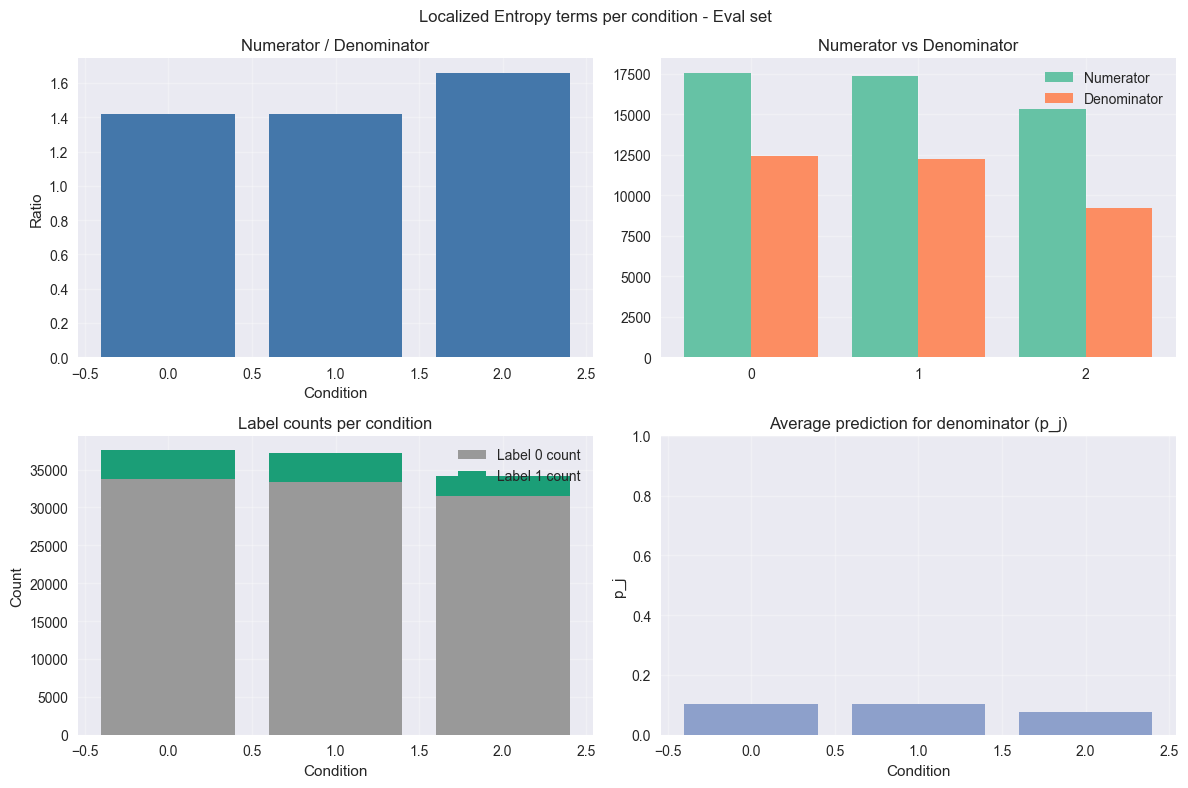

In [9]:
if plots_cfg.get('le_stats', True) or plots_cfg.get('print_le_stats_table', True):
    z_all, y_all, c_all = collect_logits(model, loaders.eval_loader, device, non_blocking=non_blocking)
    le_stats = collect_le_stats_per_condition(z_all, y_all, c_all, eps=1e-12)

    if plots_cfg.get('print_le_stats_table', True):
        print('cond	num	den	avg_p	#y=1	#y=0	ratio')
        for cond in sorted(le_stats.keys()):
            s = le_stats[cond]
            print(
                f"{cond}	{s['Numerator']:.6g}	{s['Denominator']:.6g}	"
                f"{s['Average prediction for denominator']:.6g}	"
                f"{s['Number of samples with label 1']}	"
                f"{s['Number of samples with label 0']}	"
                f"{s['Numerator/denominator']:.6g}"
            )

    if plots_cfg.get('le_stats', True):
        plot_le_stats_per_condition(le_stats, title='Localized Entropy terms per condition - Eval set')
